# Python ML/NLP : Решение задачи классификации

**ЗАДАЧА**

Построить классификатор для определения того, является ли электронное письмо спамом или нет.

**ДАННЫЕ**

Набор данных представляет из себя корпус документов, который разбит по классам:

- spam — спам
- ham — не спам

В обеих директориях датасета файлы представляют из себя набор `.mbox` файлов.

**ЗАДАЧИ**

1. Загрузите данные и подготовьте их для использования в модели классификации.
2. Используя алгоритм машинного обучения на ваш выбор, обучите классификатор на обучающей выборке.
3. Оцените производительность модели на тестовой выборке.
4. Визуализируйте несколько случайных электронных писем из тестовой
выборки и выведите предсказание модели для каждого электронного письма.

**СОДЕРЖАНИЕ** <a id='back'></a>

* [Этап 0. Объявление зависимостей и версия Python](#imports)
* [Этап 1. Загрузка и обзор данных](#download_and_review_data)
    * [1.1 Загрузка данных](#data_review)
    * [1.2 Создание датафрейма](#create_df)
* [Этап 2. Предобработка данных](#data_preprocessing)
    * [2.1 Обработка сообщений](#message_preprocessing)
    * [2.2 Удаление выбросов и дубликатов](#outliers_duplicates)
    * [2.3 Кодирование и векторизация признаков](#encoding_and_vectorization)
    * [2.4 Понижение размерности](#pca)
* [Этап 3. Обучение классификатора и оценка работы модели](#models_building)
    * [3.1 Подбор гиперпараметров](#hyperparams)
    * [3.2 Обучение моделей и выбор лучшей из них](#fit_predict)
    * [3.3 Визуализация email-ов из тестовой выборки и вывод предсказания модели для каждого email-а](#visualization)
* [Заключение](#conclusion)

**РЕШЕНИЕ**

# Этап 0: Объявление зависимостей и версия Python <a id='imports'></a>

In [1]:
import os
import mailbox
from typing import List
import pandas as pd
import numpy as np
import re
import enchant
import spacy
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
! python -V

Python 3.11.5


# Этап 1: Загрузка и обзор данных

## 1.1 Загрузка данных <a id='data_download'></a>

Разархивируем файл с данными `dataset.zip` в новый каталог `data` 

In [3]:
! mkdir data
! unzip -u "dataset.zip" -d "data"

�������� ��� 䠩� data 㦥 �������.
"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


В обеих директориях датасета файлы представляют из себя набор `.mbox` файлов. Для их чтения будем использовать библиотеку для работы с почтовыми ящиками такого формата - `mailbox`. Создадим функцию, которая извлекает содержимое всех файлов mbox в указанной папке и возвращает список содержимого электронной почты, включая тему каждого сообщения и его содержимое:

In [4]:
def read_mbox_files(folder_path: str) -> List[str]:
    email_contents = []
    for file_name in os.listdir(folder_path):
        mbox_file_path = os.path.join(folder_path, file_name)
        try:
            mbox = mailbox.mbox(mbox_file_path)
            for message in mbox:
                if message.is_multipart():
                    email_content = ''.join(str(part.get_payload(decode=True)) for part in message.walk())
                else:
                    email_content = message.get_payload(decode=True)
                email_contents.append(f'{message["subject"]} {email_content}')
        except (OSError, mailbox.Error) as e:
            print(f"An error occurred while processing {file_name}: {e}")
    return email_contents

Сформируем данные о спаме и не спаме с помощью этой функции:

In [5]:
df_ham = read_mbox_files(folder_path='data/ham')
df_spam = read_mbox_files(folder_path='data/spam')

Поглядим на 5 писем каждого типа:

In [6]:
df_average_len = lambda df: round(sum(map(len, df)) / len(df))

print('--- SPAM ---')
print(f'Total spam emails: {len(df_spam)}')
print(f'The average number of symbols in each letter: {df_average_len(df_spam)}')
display(df_spam[:5])

print('\n--- HAM ---')
print(f'Total ham emails: {len(df_spam)}')
print(f'The average number of symbols in each letter: {df_average_len(df_ham)}')
display(df_ham[:5])

--- SPAM ---
Total spam emails: 1175
The average number of symbols in each letter: 5078


['[ILUG] STOP THE MLM INSANITY b\'Greetings!\\n\\nYou are receiving this letter because you have expressed an interest in \\nreceiving information about online business opportunities. If this is \\nerroneous then please accept my most sincere apology. This is a one-time \\nmailing, so no removal is necessary.\\n\\nIf you\\\'ve been burned, betrayed, and back-stabbed by multi-level marketing, \\nMLM, then please read this letter. It could be the most important one that \\nhas ever landed in your Inbox.\\n\\nMULTI-LEVEL MARKETING IS A HUGE MISTAKE FOR MOST PEOPLE\\n\\nMLM has failed to deliver on its promises for the past 50 years. The pursuit \\nof the "MLM Dream" has cost hundreds of thousands of people their friends, \\ntheir fortunes and their sacred honor. The fact is that MLM is fatally \\nflawed, meaning that it CANNOT work for most people.\\n\\nThe companies and the few who earn the big money in MLM are NOT going to \\ntell you the real story. FINALLY, there is someone who has th


--- HAM ---
Total ham emails: 1175
The average number of symbols in each letter: 1541


['Re: New Sequences Window b\'    Date:        Wed, 21 Aug 2002 10:54:46 -0500\\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\\n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\\n\\n\\n  | I can\\\'t reproduce this error.\\n\\nFor me it is very repeatable... (like every time, without fail).\\n\\nThis is the debug log of the pick happening ...\\n\\n18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}\\n18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury\\n18:19:04 Ftoc_PickMsgs {{1 hit}}\\n18:19:04 Marking 1 hits\\n18:19:04 tkerror: syntax error in expression "int ...\\n\\nNote, if I run the pick command by hand ...\\n\\ndelta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury\\n1 hit\\n\\nThat\\\'s where the "1 hit" comes from (obviously).  The version of nmh I\\\'m\\nusing is ...\\n\\nde

Итак, исходя из этого вывода, можем сказать о:
- Неудачной обработке составных email-ов :((( ;
- Наличии форматировании (множество управляющих элементов, html-тегов) в текстах и теме каждого сообщения;
- Наличие ссылкок, чисел, излишних знаков пунктуации и других штук, которые только ухудшат работу модели машинного обучения.

Ну ничего, процесс предобработки сгладит эти недоразумения. Но для начала создадим датафрейм 

## 1.2 Создание датафрейма <a id='create_df'></a>

Удобнее всего работать с данными, если они хранятся в виде одной таблицы, в которой указано сообщение и его метка - спам или нет. Поэтому преобразуем данные из списков в объект `DataFrame` при помощи `pandas`.

In [7]:
df = pd.DataFrame({
    'Label': ['ham'] * len(df_ham) + ['spam'] * len(df_spam),
    'Message' : df_ham + df_spam
})

df = df.sample(frac=1, random_state=55).reset_index(drop=True)

df.head()

,Label,Message
0,spam,Rape!!. b'<html>\n<body>\n<p>Rape Sex!<br>\n<b...
1,ham,Photoshop Sean Connery giving us some good adv...
2,ham,"Re: New Sequences Window Noneb""> From: Chris ..."
3,spam,"please I need your assistance Noneb""MY NAME IS..."
4,ham,Re: Microsoft buys XDegress - more of a p2p/di...


# Этап 2: Предобработка данных <a id='data_preprocessing'></a>

## 2.1 Предварительная обработка сообщений <a id='message_preprocessing'></a>

Как было сказано ранее, сообщения содержат много мусора. Это затруднит обработку текста с помощью nlp-библиотек, а также работу самой модели классификации спама. 

Создадим функцию для предварительной обработки текста, которая будет включать приведение его к нормализованному формату, удаление нежелательных элементов и отбор наиболее информативных слов. Далее применим ее для столбца с сообщениями `Message` и создадим также новый столбец `Length`, который будет содержать информацию о длине каждого сообщения, что, как мне кажется, только улучшит результаты работы классификатора.

In [8]:
nlp = spacy.load("en_core_web_sm")

def text_preparation(text: str) -> str:
    # приведение слов к нижнему регистру
    text = text.lower()
    # удаление html тегов
    text = re.sub(r'<[^>]+>', "", text)
    # удаление ссылок
    text = re.sub(r"http\S+|www\S+", "", text)
    # отделение управляющих элементов
    text = text.replace('\\n', ' ')
    # удаление неалфавитных символов
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    # лемматизация и удаление стоп-слов и удаление несуществующих слов
    d = enchant.Dict("en_US")
    return ' '.join([
            token.lemma_ 
                for token in nlp(text)
                if token.text not in nlp.Defaults.stop_words and len(token.text)>1 and d.check(token.text)
        ])
     
def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['Length'] = df['Message'].apply(len)
    df['Message'] = df['Message'].apply(text_preparation)
    return df

# пример спам-сообщения в формате html
spam_example = df.iloc[0, 1]
print('Before:\n', spam_example)
print('After:\n', text_preparation(spam_example))

# пример составного не спам-сообщения 
ham_example = df.iloc[2, 1]
print('\nBefore:\n', ham_example)
print('After:\n', text_preparation(ham_example))


Before:
 Rape!!. b'<html>\n<body>\n<p>Rape Sex!<br>\n<br>\n<b><a href="http://hot12.website-hoster.com/hot/"><font size="5">CLICK HERE</font></a><br>\n</b>\n<br>\n<b>YOU MUST BE AT LEAST 18 TO ENTER!</b></p>\n<p>=============================================================================<br>\nTo be removed from our "in house" mailing list\n<a href="http://hot12.website-hoster.com/remove.html">CLICK HERE</a><br>\nand you will automatically be removed from future mailings.<br>\n<br>\nYou have received this email by either requesting more information<br>\non one of our sites or someone may have used your email address.<br>\nIf you received this email in error, please accept our apologies.<br>\n=============================================================================</p>\n</body>\n</html>\n\n\n\n'
After:
 rape rape sex click enter remove house mailing list click automatically remove future mailing receive email request information site email address receive email error accept apology


In [9]:
df_preprocessed = preprocessing(df)
df_preprocessed.head()

,Label,Message,Length
0,spam,rape rape sex click enter remove house mailing...,800
1,ham,give good advice burl local library,164
2,ham,new sequences window date aug date aug right d...,1931
3,spam,need assistance year old marry wife child die ...,1342
4,ham,buy data thing fork write file cache multiple ...,1070


In [10]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591 entries, 0 to 3590
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    3591 non-null   object
 1   Message  3591 non-null   object
 2   Length   3591 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 84.3+ KB


## 2.2 Удаление выбросов и дубликатов <a id='outliers_duplicates'></a>

Посмотрим на график распределения длины каждого из типов сообщений, используя библиотеки `matplotlib` и `seaborn`:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


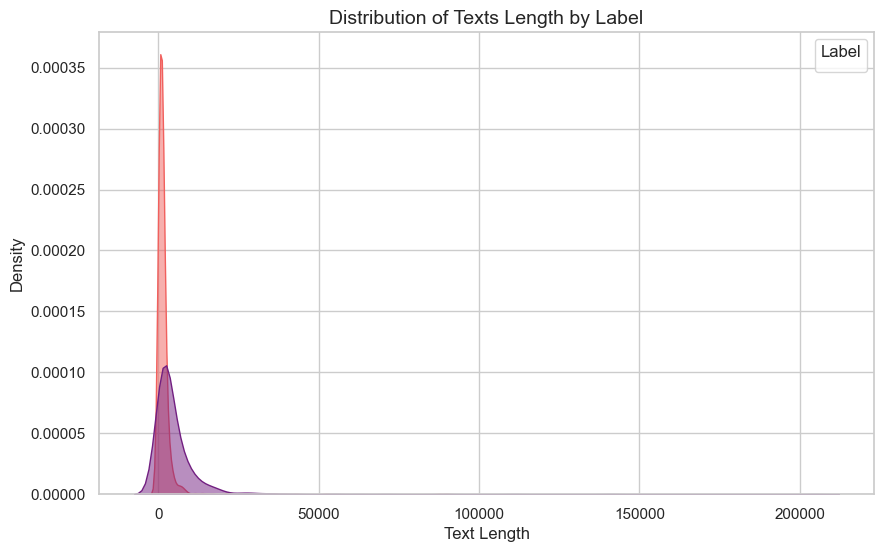

In [11]:
def plot_text_length_distribution(df: pd.DataFrame): 
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plot = sns.kdeplot(data=df, x='Length', hue='Label', palette='magma', fill=True, common_norm=False, alpha=0.5)
    plt.title("Distribution of Texts Length by Label", fontsize=14)
    plt.xlabel("Text Length", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(title='Label', title_fontsize='12', fontsize='10', loc='upper right')
    plt.show()

plot_text_length_distribution(df_preprocessed)

Как видно из графика условных распределений спам-сообщения длиннее, чем обычные.

Однако это распределение далеко от нормального ... Посмотрим, много ли данных, длина которых больше 50 тысяч, чтобы оценить масштабность проблемы :

In [12]:
df_preprocessed[df_preprocessed['Length'] > 50000]

,Label,Message,Length
107,ham,free trade free market prove ability lift soci...,89850
504,ham,bush cover waterfront view newsletter press re...,52174
780,spam,filter film capacitor engineering purchasing m...,90390
1084,spam,shop web site see shop web site see find web s...,54869
1241,spam,membership community commentary membership com...,70810
1331,spam,maintenance ne plus mars virus de internet en ...,110997
1979,spam,china motorcycle sir fetch internet month grou...,204646
2051,ham,world live comfort plenty half human race live...,87595
2202,spam,shop web site see shop web site see find web s...,54869
2313,spam,finance technology consulting center address t...,141026


Рофлс, их всего 11 :) Молча удалим выбросы, ну и в добавок дубликаты: 

In [13]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    outlier = df[['Length']]

    # Вычисление 1 и 3 квантилей
    Q1 = outlier.quantile(0.25)
    Q3 = outlier.quantile(0.75)
    # IQR-оценки
    IQR = Q3-Q1
    # Отфильтрованные данные, из которых удалены выбросы
    data_filtered = outlier[~((outlier < (Q1 - 1.5 * IQR)) |(outlier > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Копирование индексов
    index_list = list(data_filtered.index.values)
    
    print('Deleted rows:', df.shape[0]-data_filtered.shape[0])
    
    return df[df.index.isin(index_list)]

df_filtered = remove_outliers(df_preprocessed)

Deleted rows: 432


In [14]:
print('Number of duplicates:', df_filtered.duplicated().sum())

df_filtered.drop_duplicates(keep = 'first').reset_index(drop=True, inplace=True)

Number of duplicates: 189


Посмотрим на плоды наших стараний: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


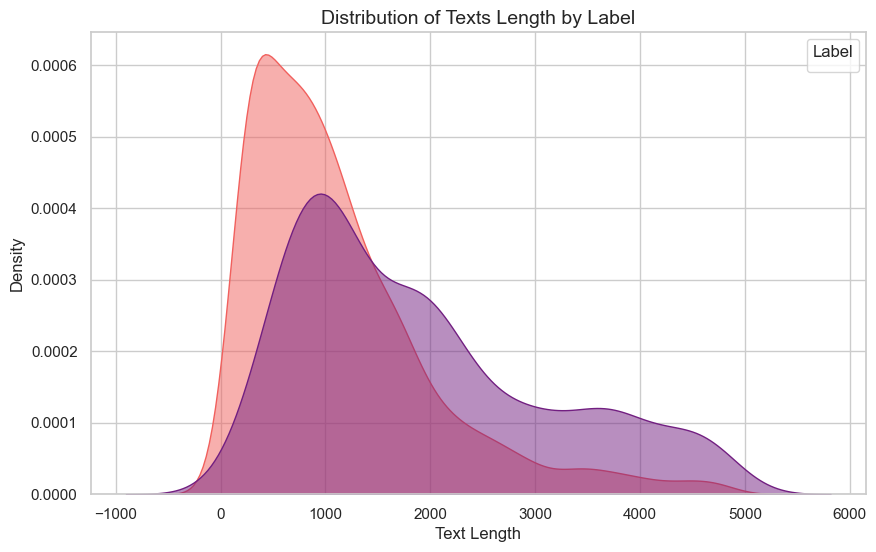

In [15]:
plot_text_length_distribution(df_filtered)

Так намного лучше :)

## 2.3 Кодирование и векторизация признаков <a id='encoding_and_vectorization'></a>

### Выделение целевого признака и предикторов

Целевой признак `Label` имеет 2 уникальных значения. Закодируем их с помощью класса `LabelEncoder` библиотеки `sklearn`:
- 1 - 'spam'
- 0 - 'pam'

In [16]:
df_filtered['Label'] = LabelEncoder().fit_transform(df_filtered['Label'])

X = df_filtered['Message']
y = df_filtered['Label']

display(X, y)

C:\Users\seito\AppData\Local\Temp\ipykernel_16716\3096981302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Label'] = LabelEncoder().fit_transform(df_filtered['Label'])


0       rape rape sex click enter remove house mailing...
1                     give good advice burl local library
2       new sequences window date aug date aug right d...
3       need assistance year old marry wife child die ...
4       buy data thing fork write file cache multiple ...
                              ...                        
3585    literary sort burl book fay opt writer residen...
3587    absurdity life mon oct write truly stuck know ...
3588    fwd jimmy carter troubling new face course kno...
3589    slaughter god original message villa rule clas...
3590    electric car write john interview wire year pu...
Name: Message, Length: 3159, dtype: object

0       1
1       0
2       0
3       1
4       0
       ..
3585    0
3587    0
3588    0
3589    0
3590    0
Name: Label, Length: 3159, dtype: int32

Алгоритмы машинного обучения не могут напрямую работать с сырым текстом, поэтому необходимо конвертировать текст в наборы цифр (векторы). Для сравнения проведём это извлечение признаков с помощью двух классов из библиотеки `sklearn` : `CountVectorizer` и `TfidfVectorizer`

### Векторизация с помощью Bag of Words (BoW)

Используемые гиперпараметры:
 - ngram_range = (1,2)- использовать униграммы и биграммы (отдельные термины или выражения из 2 слов)
 - max_df = 0.7 - игнорировать термины, которые появляются в более чем 70% документов
 - min_df = 2 - игнорировать термины, которые появляются в менее чем в 2 документах.


In [17]:
bow = CountVectorizer(ngram_range=(1,2), max_df=0.7, min_df=2)
X_bow = bow.fit_transform(X).toarray()

print(X_bow.shape)
display(bow.vocabulary_)

(3159, 39444)


{'rape': 27275,
 'sex': 30917,
 'click': 5167,
 'enter': 10228,
 'remove': 28388,
 'house': 15432,
 'mailing': 19974,
 'list': 18953,
 'automatically': 2066,
 'future': 13132,
 'receive': 27703,
 'email': 9799,
 'request': 28657,
 'information': 16322,
 'site': 31532,
 'address': 520,
 'error': 10362,
 'accept': 126,
 'apology': 1304,
 'rape sex': 27276,
 'sex click': 30920,
 'click enter': 5186,
 'enter remove': 10236,
 'remove house': 28415,
 'house mailing': 15438,
 'mailing list': 19981,
 'list click': 18970,
 'click automatically': 5171,
 'automatically remove': 2078,
 'remove future': 28411,
 'future mailing': 13147,
 'mailing receive': 19988,
 'receive email': 27715,
 'email request': 9907,
 'request information': 28672,
 'information site': 16396,
 'site email': 31551,
 'email address': 9805,
 'address receive': 576,
 'email error': 9840,
 'error accept': 10363,
 'accept apology': 127,
 'give': 13543,
 'good': 13776,
 'advice': 724,
 'burl': 3609,
 'local': 19262,
 'library': 1

### Векторизация с помощью Term Frequency Inverse Document Frequency (TF-IDF)

Используемые гиперпараметры:
- sublinear_tf = True - применить сублинейное масштабирование (делает вес TF менее линейно растущим, что может быть полезным для учета насыщенности текста ключевыми словами).

In [18]:
tf_vectorizer = TfidfVectorizer(sublinear_tf=True)
X_tfidf = tf_vectorizer.fit_transform(X).toarray()

print(X_tfidf.shape)
display(tf_vectorizer.get_feature_names_out())

(3159, 10744)


array(['aa', 'ab', 'abandon', ..., 'zone', 'zoo', 'zoom'], dtype=object)

## 2.4 Понижение размерности <a id='pca'></a>

В качестве итогового предиктора выберем X с векторизацией TF-IDF. Проанализируем долю объясненной дисперсии для корректного определения числла компонент :

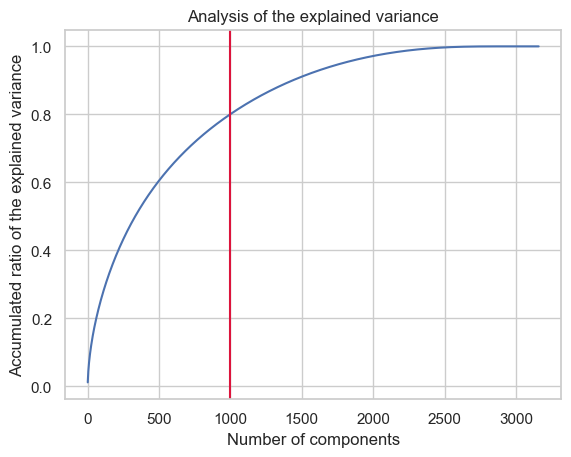

In [19]:
# Создаем экземпляр PCA
pca = PCA()

# Обучаем PCA на данный X
pca.fit(X_tfidf)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Визуализация объясненной дисперсии
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.axvline(x = 1000, color='crimson')
plt.xlabel("Number of components")
plt.ylabel("Accumulated ratio of the explained variance")
plt.title("Analysis of the explained variance")
plt.grid(True)
plt.show()

Сократим число компонент X с 10744 до 1000. Как показывает график, такое преобразование сохранит приблизительно 80% исходных данных

In [20]:
pca = PCA(n_components=1000)

X_tfidf_pca = pca.fit_transform(X_tfidf, y)
sum(pca.explained_variance_ratio_)

0.7959133109071611

In [21]:
X_pca = pd.DataFrame(
    X_tfidf_pca,
    index=df_filtered.index
)
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.186557,0.179528,-0.094032,0.127252,0.089964,-0.070383,-0.100551,0.131529,0.069800,0.019088,...,0.017528,0.003126,0.002370,-0.008892,0.003521,-0.007725,-0.001586,0.000814,0.005695,0.021321
1,-0.012267,-0.131968,0.073244,-0.018742,0.000558,-0.074419,0.028231,0.046212,0.029505,-0.043330,...,0.037086,-0.016532,-0.024072,-0.027373,-0.016207,-0.008721,0.026353,0.006755,-0.003395,0.028434
2,-0.174242,0.047991,-0.032060,-0.023190,-0.051275,0.316997,0.147370,0.083362,0.049035,0.105555,...,0.010923,-0.006874,0.018465,0.015549,-0.024635,-0.004718,-0.006033,0.003887,-0.001069,-0.004241
3,0.091537,-0.024350,0.015767,-0.031667,-0.043627,0.035263,-0.040899,-0.051280,0.001726,-0.078413,...,0.024858,-0.006484,-0.026806,0.008750,0.016968,0.007561,0.005770,-0.002344,-0.001127,0.023281
4,-0.072439,-0.017990,0.003115,-0.023377,-0.023353,0.074084,-0.017572,0.021136,0.023597,0.013206,...,0.000548,0.010728,-0.017134,0.002586,-0.006049,0.010141,-0.013486,0.001098,0.009535,-0.021428


# Этап 3: Обучение классификатора и оценка работы модели <a id='models_building'></a>

Данные имеют табличный вид, значит можем приступать к обучению модели. В качестве классификаторов возьмем `SVC` (метод опорных векторов) и `RandomForestClassifier` (случайный лес), а потом выберем из них лучший.

`Support Vector Classifier` - алгоритм машинного обучения для задач классификации, который строит гиперплоскость в многомерном пространстве, отделяющую один класс от другого. 

`Random Forest Classifier` - алгоритм машинного обучения для задач классификации, который использует технику ансамблирования для построения множества деревьев решений и объединения их прогнозов для улучшения общей точности.

## 3.1 Подбор гиперпараметров <a id='hyperparams'></a>

Для метода опорных векторов будем подбирать 2 гиперпараметра:
- `kernel`(ядро) - определяет вид гиперплоскости (ядра), используемый моделью;
- `gamma`(коэффициент ядра) - влияет на "гибкость" гиперплоскости .

In [22]:
svc_classifier = SVC()

params_SVC = {'kernel': ['linear', 'sigmoid'],
             'gamma': [0.05, 0.5, 1, 2]}
gs_SVC = GridSearchCV(estimator=svc_classifier, 
                 param_grid=params_SVC,
                 verbose=1, 
                 scoring='accuracy') 
gs_SVC.fit(X_pca, y)

bp_gs_SVC = gs_SVC.best_params_
display(bp_gs_SVC)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


{'gamma': 1, 'kernel': 'sigmoid'}

Для ансамбля решающих деревьев будем подбирать гиперпараметр `n_estimators`, который отвечает за количество используемых деревьев.

In [23]:
rfc_classifier = RandomForestClassifier()

params_RFC = {'n_estimators': [50, 100, 150]}
gs_RFC = GridSearchCV(estimator=rfc_classifier, 
                 param_grid=params_RFC,
                 verbose=1, 
                 scoring='accuracy') 
gs_RFC.fit(X_pca, y)

bp_gs_RFC = gs_RFC.best_params_
display(bp_gs_RFC)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


{'n_estimators': 150}

## 3.2 Обучение моделей и выбор лучшей из них <a id='fit_predict'></a>

Наконец, обучим модели на тренировочной выборке. В качестве оценки построенных классификаторов будем использовать текстовый отчет, показывающий основные показатели классификации (`classification report`), матрицу ошибок (`confusion matrix`) и точность (`accuracy`)

In [24]:
models = [
    SVC(**bp_gs_SVC),
    RandomForestClassifier(**bp_gs_RFC, random_state = 2)
]

def test_clf_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    for model in models:
        mdl = model.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
        print(f'Results for {type(model).__name__}: \n')
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        print('Accuracy: ', accuracy_score(y_test, y_pred))
        print()

    return X_test, y_test

In [25]:
X_test, y_test = test_clf_models(X_pca, y)

Results for SVC: 

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       458
           1       1.00      0.93      0.96       174

    accuracy                           0.98       632
   macro avg       0.99      0.97      0.98       632
weighted avg       0.98      0.98      0.98       632

[[458   0]
 [ 12 162]]
Accuracy:  0.9810126582278481

Results for RandomForestClassifier: 

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       458
           1       1.00      0.81      0.90       174

    accuracy                           0.95       632
   macro avg       0.97      0.91      0.93       632
weighted avg       0.95      0.95      0.95       632

[[458   0]
 [ 33 141]]
Accuracy:  0.9477848101265823



Таким образом, лучшей моделью для классификации сообщений о спаме оказалась `SVC(kernel = 'sigmoid', gamma = 1)`

In [26]:
best_model = models[1]

## 3.3 Визуализация email-ов из тестовой выборки и вывод предсказания модели для каждого email-а <a id='visualization'></a>

Выберем 10 случайных писем из тестовой выборки с помощью `random.choises`. 

In [28]:
test_emails = df_filtered.loc[random.choices(X_test.index, k=10)]
test_emails

,Label,Message,Length
3390,0,sell wed bliss ouch number come study couple t...,2234
3101,1,big money casino site maxim casino ad click fr...,4603
3144,0,excite burl excite,323
2894,0,source tree available burl like live bleeding ...,344
3014,0,electric car cheer rah begin forward text stat...,4092
3007,0,sort write run desktop home work result window...,984
3144,0,excite burl excite,323
3233,0,rpm dependency write way resolve knowledge dow...,756
3058,0,release finally mon pm mason write razor suppo...,1026
3114,0,google pr send message new news service maybe ...,653


Визуализируем эти письма, выведем для них предсказание лучшей модели и сопоставим с ответом:

In [38]:
for email_number in range(len(test_emails)):
	email= test_emails.iloc[email_number]
	print(f"E-mail message № {email_number+1} from the test sample: \n{email.Message}")

	email_as_floats = X_test.loc[email.name].values.reshape(1, -1)

	predict = 'Ham' if best_model.predict(email_as_floats) == [0] else 'Spam'
	answer = 'Ham' if y_test.loc[email.name] == [0] else 'Spam'
	print('	Model predicted label "{}".\n	Actually e-mail is "{}"\n\n'.format(predict, answer))

E-mail message № 1 from the test sample: 
sell wed bliss ouch number come study couple thousand swede reference sexual preference find point sexual activity follow power curve people la wilt chamberlain have large number sexual contact en short period time tendency man partner woman idea statistical ignoramus fact man woman extremely promiscuous end curve mean extreme result group man chiefly sex man gay man anecdotal evidence case extreme promiscuity gay man read randy band play write bathhouse culture discuss gay politic time subculture radical gay man argue act argument have partner essential gay actually explicitly political statement monogamy artifact straight culture view die way point book condemn role bathhouse culture play spread aid epidemic eventually kill let accurate cult promiscuity particular gay community tom
	Model predicted label "Ham".
	Actually e-mail is "Ham"


E-mail message № 2 from the test sample: 
big money casino site maxim casino ad click free maxim casino p

# Заключение <a id='conclusion'></a>

- Все задачи выполнены и все цели достигнуты.
- Проведена загрузка данных: архив с информацией был распакован, из каждого электронного письма были извлечены тема сообщения и его содержимое.
- Подготовка данных для использования в модели классификации включала нормализацию текста сообщений, удаление нежелательных элементов и отбор наиболее информативных слов.
- Проведена векторизация писем с использованием методов Bag of Words (BoW) и TF-IDF, после чего был выбран наиболее эффективный из них. Далее произведено снижение размерности полученной выборки с помощью метода главных компонент (PCA).
- Набор данных был разделен на обучающую и тестовую выборки в соотношении 80:20, соответственно.
- Проведено обучение моделей SVC и RandomForestClassifier на обучающей выборке, после чего на основе предсказаний моделей на тестовой выборке была выбрана наиболее эффективная - модель SVC.
- Оценка моделей произведена с использованием метрик accuracy, classification_report и confusion_matrix.
- Визуализированы некоторые электорнные письма из тестовой выборки и определён результат, являются ли эти сообщения спамом или нет.

**КОНЕЦ!**